In [ ]:
# libraries
import os
import torch
import evaluate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from transformers import TrainingArguments, Trainer

In [3]:
# path
filename = os.path.join("data", "combined_data.csv")

In [4]:
# load data
df = pd.read_csv(filename)

In [5]:
# combining news title and text columns
df['combined_text'] = df['title'] + ' ' + df['text']

# remove unused columns
df = df.drop(columns=['date', 'title', 'text'])

# remove duplicates
df = df.drop_duplicates()

In [6]:
# downsample dataset
df_small, _ = train_test_split(
                                df, 
                                train_size=0.01, # keep 1 %
                                stratify=df["label"], 
                                random_state=42
                            )

In [7]:
# split data in train and test
texts = df_small["combined_text"]
labels = df_small["label"]
train_df, test_df = train_test_split(
                                    df_small, 
                                    test_size=0.2,     # create an 80/20 split
                                    random_state=42, 
                                    stratify=df_small['label']    # keeps label balance in both splits
)

In [8]:
# fit tokenizer and classification model
model_name = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["combined_text"], truncation=True)

# convert to huggingface dataset and tokenize
train_dataset = Dataset.from_pandas(train_df).map(tokenize, batched=True)
test_dataset = Dataset.from_pandas(test_df).map(tokenize, batched=True)

# Set the format for PyTorch
train_dataset.set_format("torch")
test_dataset.set_format("torch")

# prepare hyperparameters
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    logging_dir="./logs"
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/356 [00:00<?, ? examples/s]

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

In [9]:
# use padding to add zeros to ensure same length
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [10]:
# predict and evaluate
def compute_metrics(eval_pred):
    """Take predicted logits and true labels to compute F1 score"""
    logits, labels = eval_pred

    # convert to predicted class label (index of highest logit)
    predictions = np.argmax(logits, axis=-1)

    # load and compute F1 from "evaluate" library
    f1_metric = evaluate.load("f1")
    f1 = f1_metric.compute(
        predictions=predictions,
        references=labels,
        average="macro"
    )["f1"]
    
    return {"f1": f1}

In [11]:
# train model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

/home/ucloud/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


TrainOutput(global_step=45, training_loss=0.35616493225097656, metrics={'train_runtime': 146.2492, 'train_samples_per_second': 2.434, 'train_steps_per_second': 0.308, 'total_flos': 47127346874976.0, 'train_loss': 0.35616493225097656, 'epoch': 1.0})

In [ ]:
# evaluate model
trainer.evaluate()

In [ ]:
# extract predictions for confusion matrix
predictions_output = trainer.predict(test_dataset)
logits = predictions_output.predictions  # raw logits
y_pred = np.argmax(logits, axis=-1)      # predicted class labels
y_true = predictions_output.label_ids    # true labels

/home/ucloud/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Text(0.5, 1.0, 'Confusion matrix')

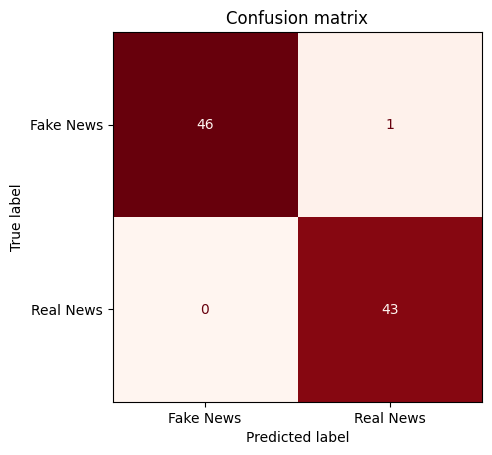

In [ ]:
# confusion matrix
labels = ["Fake News", "Real News"]
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Reds", colorbar=False)
plt.title("Confusion matrix") 